## Credit Risk Analysis Using Supervised Learning Models

### Importing the Relevant Libraries & Data

In [160]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("cr_loan2.csv")

In [4]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


### Exploratory Data Analysis

In [6]:
df.shape

(32581, 12)

There are 32,581 rows corresponding to 12 columns that hold the customer's behavioural and application data.
Behavioural data includes variables such as "Age" and "Income," whereas Application data relates to the nature of the loan, such as "Loan Amount" and "Loan Interest Rate"

In [12]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

All the columns seem relevant for our analysis. Need to dive a bit deeper to make the call. 

In [15]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

There are 4 categorical variables in the dataset; "Home Ownership," "Loan Intent," "Loan Grade," and the target variable "Default"

In [18]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


A couple of outliers can be seen — specifically, there is someone in the dataset who is 144 years old (this debt facility should be written-off). 

The average age of a loan borrower is 27 years old, and the average loan amount is $9,589. The average person gaining a credit facility has been employed for 4 and a half year. 

The minimum loan amount is $500 and the youngest borrower is 20 years old - this is potentially higher risk, but the loan amount is not too much. 

In [21]:
df['loan_grade'].value_counts()

loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64

Most of the credit facilities provided by the bank/financial institution in this dataset are of Grade A and Grade B - meaning, the borrower's creditworthiness and the associated risk with the facility is not too high. Roughly **21,228 cases or 65.2%** of the cases are categorized under **Grade A and Grade B.**

Additionally, the lower Grade E, F, and G have higher risks associated with them - the issuing authority must have done their due diligence while issuing this facility. 

In [24]:
df.describe(include='O')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


In [26]:
df['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [28]:
df['loan_intent'].unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

Checking the distribution of the categorical variables, we can see that most people fall under the rent cateogy, have taken out an educational loan, and are categorized as Grade A (lower risk) borrowers.  

In [31]:
df.duplicated().value_counts()

False    32416
True       165
Name: count, dtype: int64

The dataframe has 165 values that are duplicated. Under normal circumstances, we would decide what to do with duplicated values such as dropping the values, but in this case, we can't tell whether the duplicated values are due to the same customer information populated twice/thrice or whether they are different customers. 

Hence, since we do not have visibility on unique identifiers, we will keep this data in the mix instead of dropping the rows. 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [36]:
df['person_emp_length'].unique()

array([123.,   5.,   1.,   4.,   8.,   2.,   6.,   7.,   0.,   9.,   3.,
        10.,  nan,  11.,  18.,  12.,  17.,  14.,  16.,  13.,  19.,  15.,
        20.,  22.,  21.,  24.,  23.,  26.,  25.,  27.,  28.,  31.,  41.,
        34.,  29.,  38.,  30.])

895 cases have missing values in the "Employment Length" column. That means, 2.75% of the total cases are missing from this column.

Additionally, 3,116 values are missing from the "Loan Interest Rate" column. This accounts for 9.56% of the total observations. 

We need to check if these values are Missing At Random, Missing Completely At Random, or Missing Not At Random. 

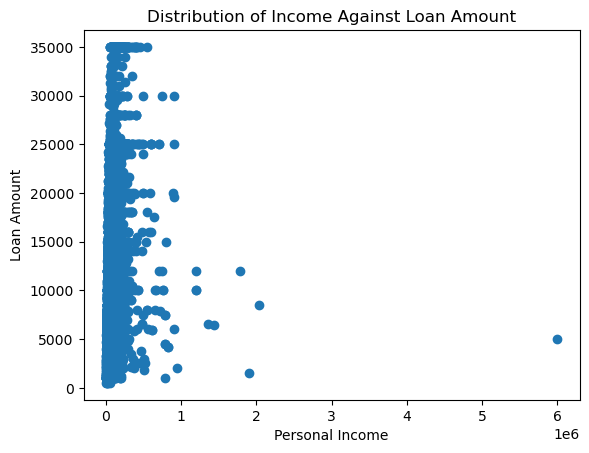

In [40]:
plt.scatter(df['person_income'], df['loan_amnt'])
plt.title('Distribution of Income Against Loan Amount')
plt.xlabel('Personal Income')
plt.ylabel('Loan Amount')
plt.show()

The graph plots Loan Amount (y-axis) across Personal Income (x-axis). The graph shows us that loan amount does not scale proportionally with income - meaning, a higher income does not imply a higher loan amount. 

There are a couple of outliers in the data, such as the point around USD6M in income, and all loan amounts seem to be below USD35,000. 

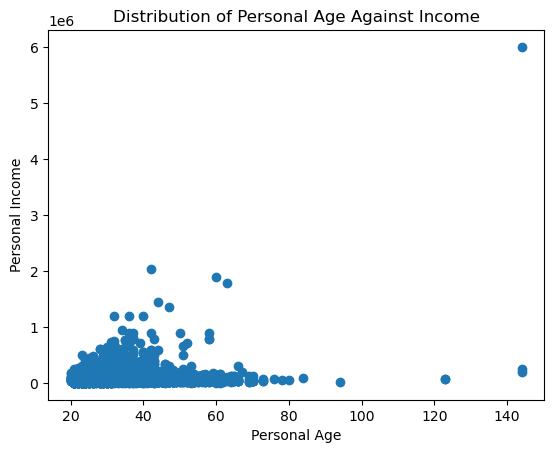

In [43]:
plt.scatter(df['person_age'], df['person_income'])
plt.title('Distribution of Personal Age Against Income')
plt.xlabel('Personal Age')
plt.ylabel('Personal Income')
plt.show()

There exists a weak positive relationship between age and income. We do not necessarily see income scale positively as the person's age increases across the dataset. 

Additionally, outliers with Ages>100 exist and should be worth exploring as to why this is happening. 

The majority of the clusters are present between Ages 20 and 60, with an income around USD200-300K. 

In [46]:
pd.crosstab(df['loan_grade'], df['loan_status'])

loan_status,0,1
loan_grade,,
A,9704,1073
B,8750,1701
C,5119,1339
D,1485,2141
E,343,621
F,71,170
G,1,63


In [48]:
pd.crosstab(df['loan_grade'], df['loan_status'], normalize='index').style.format("{:0.0%}")

loan_status,0,1
loan_grade,,
A,90%,10%
B,84%,16%
C,79%,21%
D,41%,59%
E,36%,64%
F,29%,71%
G,2%,98%


As the Grade for loans decreases, the credit risk increases - this intuitively makes sense as we expect lower Grade credit loans to have a higher probability of default from the borrower. 

There are 63 consumers who defaulted on their loan in Grade G, 170 who defaulted in Grade F and 621 in Grade E. While the absolute number of defaults is higher in Grade A (1,073), proportionally, there are lower defaults in Grade A (9.96%) as compared with Grade G (98.4%), Grade F (70.54%), so on and so forth. 

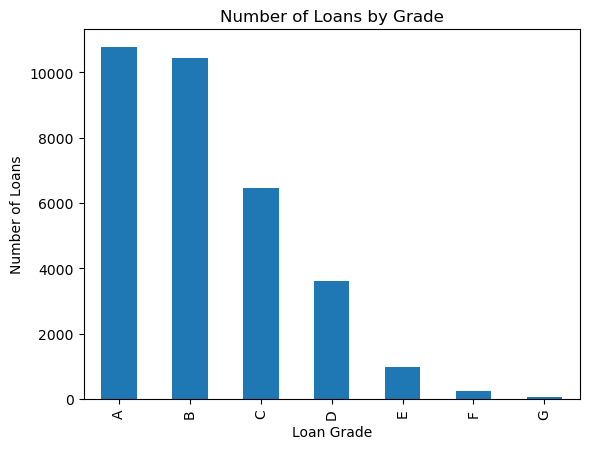

In [51]:
df['loan_grade'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Loan Grade')
plt.ylabel('Number of Loans')
plt.title('Number of Loans by Grade')
plt.show()

In [53]:
pd.crosstab(df['loan_intent'], df['loan_status'], normalize='index').style.format("{:0.0%}")

loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,71%,29%
EDUCATION,83%,17%
HOMEIMPROVEMENT,74%,26%
MEDICAL,73%,27%
PERSONAL,80%,20%
VENTURE,85%,15%


Comparing across what the loan was utilized for, we can see that the highest percentage of non-repayments (defaults) are in the "Debt Consolidation" category with 29% of consumers defaulting, with "Medical" being a close second with 27% defaults.

The highest number of repayments are in "Venture" loans with 85% consumers repaying - rendering the loan as somewhat of a safe investment (venture loans are somewhat of a secure loan).

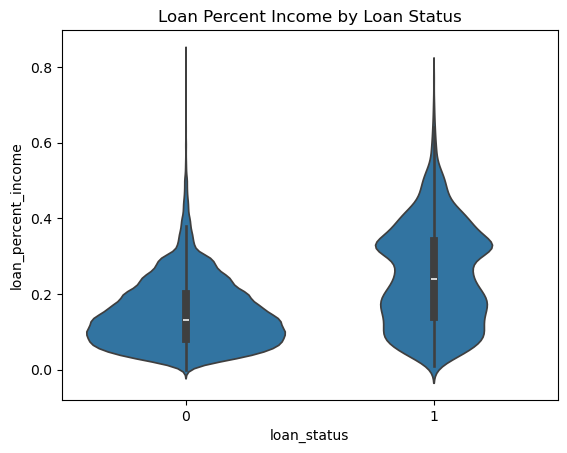

In [56]:
sns.violinplot(
    x='loan_status',
    y='loan_percent_income',
    data=df
)
plt.title('Loan Percent Income by Loan Status')
plt.show()

It seems like a higher debt-to-income is associated with the probability of defaulting. This means that consumers who defaulted had a higher debt-to-income ratio. 

### Essential Preprocessing Steps

In [60]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [62]:
df_filtered = df[df['person_age'] < 100]

Filtering out outlier data where the age of the person is above 100; this is highly improbable, and even if this is the case, the account should be completely written-off. 

Data quality issue as there are incorrect entries in the system. 

In [65]:
df_filtered.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32576.000000,3.257600e+04,31681.000000,32576.000000,29461.000000,32576.000000,32576.000000,32576.000000
mean,27.718044,6.588214e+04,4.789527,9589.117755,11.011547,0.218197,0.170212,5.803966
std,6.204990,5.253499e+04,4.142706,6321.886846,3.240623,0.413029,0.106778,4.053791
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,94.000000,2.039784e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [67]:
df[df['person_emp_length'] > 50]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


Also filtering out cases where the Employment length is greater than 50 - there are only 2 cases like this where the length of employment is mentioned as 123 - again, highly improbable. 

In [70]:
df_filtered = df_filtered[df_filtered['person_emp_length'] < 50]

In [72]:
df[df['person_income'] > 2000000]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
30049,42,2039784,RENT,0.0,VENTURE,C,8450,12.29,0,0.0,Y,15
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.0,N,25


Two outlier cases where the income is greater than USD2M.

In [75]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31679 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31679 non-null  int64  
 1   person_income               31679 non-null  int64  
 2   person_home_ownership       31679 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 31679 non-null  object 
 5   loan_grade                  31679 non-null  object 
 6   loan_amnt                   31679 non-null  int64  
 7   loan_int_rate               28632 non-null  float64
 8   loan_status                 31679 non-null  int64  
 9   loan_percent_income         31679 non-null  float64
 10  cb_person_default_on_file   31679 non-null  object 
 11  cb_person_cred_hist_length  31679 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.1+ MB


In [77]:
df_filtered[df_filtered['loan_int_rate'].isna()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,Y,4
57,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,N,4
59,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,Y,3
62,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,C,1400,NaN,1,0.29,Y,28
32552,65,45900,RENT,2.0,EDUCATION,C,10000,NaN,0,0.22,Y,19
32553,54,20000,RENT,2.0,MEDICAL,C,5000,NaN,0,0.25,N,28
32569,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,NaN,0,0.13,N,23


In [79]:
df_filtered = df_filtered.dropna(subset=['loan_int_rate'])

Dropping NAN values from the dataset. Having NAN's in the loan's interest rate will make the algorithm not run.

### Modeling

In [83]:
df = df_filtered

Defining X and Y - target and dependent variables. 

In [86]:
X = df.drop(columns='loan_status')
y = df['loan_status']

Splitting the data into train and test splits - test size will be 40% of the total dataset.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Defining numerical and categorical features to OneHotEncod the Categorical Features and run the algorithms.

In [92]:
num_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
               'cb_person_cred_hist_length']

cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

#### Pipeline for Encoding Categorical Features & Scaling Numeric Features

In [95]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [97]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [99]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

### Modeling - Logistic Regression

In [101]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    ))
])

In [103]:
log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [105]:
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression AUC: 0.8737269498747773
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      8972
           1       0.55      0.78      0.65      2481

    accuracy                           0.81     11453
   macro avg       0.74      0.80      0.76     11453
weighted avg       0.85      0.81      0.83     11453



In [164]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)
print(conf_matrix)

[[7388 1584]
 [ 536 1945]]


#### Overfitting or Underfitting

In [173]:
y_train_prob_lr = log_reg.predict_proba(X_train)[:, 1]
train_auc_lr = roc_auc_score(y_train, y_train_prob_lr)

y_test_prob_lr = log_reg.predict_proba(X_test)[:, 1]
test_auc_lr = roc_auc_score(y_test, y_test_prob_lr)

print(f"LR Train AUC: {train_auc_lr:.4f}")
print(f"LR Test AUC:  {test_auc_lr:.4f}")

LR Train AUC: 0.8729
LR Test AUC:  0.8737


### Modeling - XGBoost

In [111]:
xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        random_state=42
    ))
])

In [113]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='m...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [115]:
y_pred_xgb = xgb_pipe.predict(X_test)
y_prob_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

In [117]:
print("XGBoost AUC:", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost AUC: 0.9414389080597022
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8972
           1       0.95      0.73      0.83      2481

    accuracy                           0.93     11453
   macro avg       0.94      0.86      0.89     11453
weighted avg       0.93      0.93      0.93     11453



In [166]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix_xgb)

[[8879   93]
 [ 666 1815]]


#### Overfiting or Underfitting 

In [179]:
y_train_prob_xgb = xgb_pipe.predict_proba(X_train)[:, 1]
train_auc_xgb = roc_auc_score(y_train, y_train_prob_xgb)

y_test_prob_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
test_auc_xgb = roc_auc_score(y_test, y_test_prob_xgb)

print(f"xgb Train AUC: {train_auc_xgb:.4f}")
print(f"xgb Test AUC:  {test_auc_xgb:.4f}")

xgb Train AUC: 0.9643
xgb Test AUC:  0.9414


### PD Modeling & Business Insights

In [148]:
results = X_test.copy()
results['actual_default'] = y_test.values
results['pd_logistic'] = y_prob_lr
results['pd_xgboost'] = y_prob_xgb

In [150]:
bins = [0, 0.05, 0.10, 0.20, 1.0]
labels = ['Very Low', 'Low', 'Medium', 'High']

results['risk_bucket'] = pd.cut(results['pd_xgboost'], bins=bins, labels=labels)

In [152]:
results['risk_bucket'].value_counts(normalize=True)

risk_bucket
Very Low    0.400681
High        0.250939
Low         0.203440
Medium      0.144940
Name: proportion, dtype: float64

25% of the portfolio's customers fall into the High Probability of Default category - this is risk for the financial institution. If unmanaged, this portfolio will account for majority of the credit loss. From a strategy perspective, give this bucket high rates, increase targeted collections efforts through proactive monitoring or increase chances of rejection.

For profitability gains, roughly 60% of the customers fall under Very Low and Low Probability of Default. 

In [155]:
results.groupby('risk_bucket')['actual_default'].mean()

risk_bucket
Very Low    0.017651
Low         0.060515
Medium      0.131325
High        0.710160
Name: actual_default, dtype: float64

Here, we check the defaults per buckets. These insights follow the norms of monotonicity as defaults exponentially scale as we move down the buckets. 

In the High Risk bucket-which accounts for 25% of the portfolio-7 out of 10 customers is expected to default. This segment dominates losses. In the Medium Risk bucket, the default is 13% roughly, which means that risk is manageable. 

Targeted strategy would be: 

Very Low Risk = Auto-approval. 

Low Risk = Standard Industry Rates (BAU). 

Medium Risk = Tighten the limits and monitor to decrease chances of default. 

High Risk = Decline the credit facility or require additional mitigants such as secured loans. 

In [158]:
## End